# Classifying flowers with Fastai


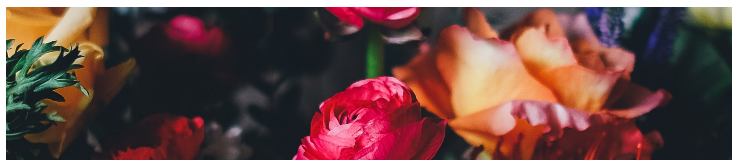


    
**In this kernel, I will briefly explain how to participate in this competition with latest version of fastaiv2, which is scheduled to be released on early June.**

*Update 25/06/2022*

Since fastai has changed a lot after I initially wrote this notebook, I am adding a new section on how to create a baseline model with latest version of fastai, also this time I am making more updates to this notebook in term of explaination.

<font size=3 color="red">Please upvote this kernel if you like it. It motivates me to produce more quality content :)</font>

# Contents

* [<font size=4>Installation</font>](#1)
* [<font size=4>Flower classification - High level API</font>](#2)
* [<font size=4>Flower classification - low level API</font>](#3)
* [<font size=4>Train Model</font>](#4)
* [<font size=4>Look at our results</font>](#5)
* [<font size=4>Ending Note</font>](#6)

# Installation <a id='1'>

In [ ]:
! pip install -Uqq timm==0.6.2.dev0

In [ ]:
! pip install git+https://github.com/fastai/fastai.git@fastai

Just importing the libraries, this is a bad practice of importing everthing, don't you know that?


In [ ]:
from fastai.vision.all import *
import matplotlib.pyplot as plt

# Flower classification - High level API <a id='2'>

In [ ]:
# Load the data
flower_path = '/kaggle/input/104-flowers-garden-of-eden/jpeg-192x192'
TRAIN_DIR  = flower_path + '/train'
VAL_DIR  = flower_path + '/val'
TEST_DIR  = flower_path + '/test/'

Now that we know this, let's build a basic transformation pipeline that looks something like so:

- Resize our images to a fixed size (224x224 pixels)
- After they are batched together, choose a quick basic augmentation function
- Normalize all of our image data

Let's build it!

In [ ]:
item_tfms = Resize(192)
batch_tfms = aug_transforms(size=224, min_scale=0.75)

As noted earlier, there are two kinds of transforms: `item_tfms and batch_tfms`. Each do what it sounds like: an item transform is applied on an individual item basis, and a batch transform is applied over each batch of data. The role of the item transform is to prepare everything for a batch level (and to apply any specific item transformations you need), and the batch transform is to further apply any augmentations on the batch level efficently (normalization of your data also happens on a batch level). One of the biggest differences between the two though is where each is done. Item transforms are done on the CPU while batch transforms are performed on the GPU.

In [ ]:
aug_transforms?

In [ ]:
# High level fastai API using fastai
data = ImageDataLoaders.from_folder(flower_path, train='train', valid='val',batch_tfms=batch_tfms, 
                                   item_tfms=item_tfms)

In [ ]:
data.show_batch(max_n=9)

Calling ImageDataloader and specifying flower_path, trasformations and batch size

# Flower classification - medium-level API <a id='3'>

We'll all wrap them up in a nice little package of a DataBlock. Think of the DataBlock as a list of instructions to do when we're building batches and our DataLoaders. It doesn't need any items explicitly to be done, and instead is a blueprint of how to operate. We define it like so:

In [ ]:
path = Path(TRAIN_DIR)
path.ls()

In [ ]:
flower_blocks = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(valid_name="val"),
    get_y=[parent_label],
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, max_rotate=30, min_scale=0.75),
)

In [ ]:
dls = flower_blocks.dataloaders(TRAIN_DIR)

In [ ]:
dls.show_batch(max_n=9)

In [ ]:
arch = "convnext_base_in22k"
learn = vision_learner(dls, arch, metrics=[error_rate, F1Score()],  cbs=[MixUp()])
learn.fine_tune(20)

# Train model <a id='4'>

In [ ]:
from torchvision.models import resnet18
from fastai.metrics import accuracy_multi

In [ ]:
from sklearn.model_selection import StratifiedKFold

We used 5 Folds for K-Fold Cross Validation, we'll recreate the process based on this notebook. We'll also use a few different image augmentations and Test Time Augmentation (TTA).

In [ ]:
imgs = get_image_files(path)
random.shuffle(imgs)
lbls = [parent_label(im) for im in imgs]

In [ ]:


def get_dls(size, val_idx, bs=64):
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        get_y=parent_label,
        splitter=IndexSplitter(val_idx),
        item_tfms=Resize(128),
        batch_tfms=[
            RandomResizedCrop(size),
            *aug_transforms(
                mult=1.0,
                max_rotate=30.0,
                max_zoom=1.5,
                max_lighting=0.8,
                max_warp=0.3,
                p_lighting=0.9,
            ),
            Normalize.from_stats(*imagenet_stats),
        ],
    )
    return dblock.dataloaders(path, bs=bs)



We'll also be utilizing the progressive resizing technique, where we train initially on a smaller set of images before moving upwards to a larger size. We're doing this as our data comes from a variety of sized images, so this will be a good way to get the most out of our data.

Now you're probably confused about the difference between pre-sizing and progressive resizing. I'll try to explain the difference. Pre-sizing is where we initially make our image larger before applying a random crop of the image (such as 256x256 to 224x224). This can bring an opportunity for some smaller or finer details to show up more prominantly.

Progressive resizing is a technique where we start training at a small image size and then increase this image size while training. Here we'll start at an image size of 128x128 and then train on an image size of 224x224 afterwards

Now let's make a function to help us build our DataLoaders in such a way as to support progressive resizing


In [ ]:
# import timm
# from sklearn.model_selection import StratifiedKFold

# val_pct = []
# skf = StratifiedKFold(n_splits=2, shuffle=True)
# i = 0
# arch = "convnext_base_in22k"

# for _, val_idx in skf.split(np.array(imgs), lbls):
#     dls = get_dls(bs=32, size=224, val_idx=val_idx)
#     learn = vision_learner(dls, arch, metrics=[error_rate, F1Score()],  cbs=[MixUp()])
#     learn.fine_tune(50)
#     i+=1
#     learn.export(f"MODEL-{i}")

In [ ]:
# %%time
# val_pct = []
# skf = StratifiedKFold(n_splits=2, shuffle=True)
# i = 0

# for _, val_idx in skf.split(np.array(imgs), lbls):
#     dls = get_dls(bs=32, size=128, val_idx=val_idx)
#     learn = vision_learner(dls, resnet18, metrics=accuracy)
#     learn.fine_tune(1, cbs=[EarlyStoppingCallback(monitor='accuracy')])
# #   due to huge compute requirements I am not doing progressive resizing at the moment
# #     learn.dls = get_dls(32, 224, val_idx)
# #     learn.fine_tune(3, 1e-3, cbs=[EarlyStoppingCallback(monitor='accuracy')])
#     preds, targs = learn.tta()
#     print(accuracy(preds, targs).item())
#     val_pct.append(accuracy(preds, targs).item())
#     i+=1

# Look at our results <a id='5'>

In [ ]:
interep = ClassificationInterpretation.from_learner(learn)
losses, idxs = interep.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
interep.plot_top_losses(9, figsize=(15,10))

In [ ]:
interep.most_confused(min_val=3)

In [ ]:
interep.plot_confusion_matrix()

## Update with latest model of fast.ai

Recently fast.ai had integerated with timm also know as pytorch image models. The [pytorch image models repository](https://github.com/rwightman/pytorch-image-models) contains lot of latest architecture like Convnext, Swin transformers, VIT, Levit and lot more models. I am really thankful to Ross Wightman for creating 100s of state of art models publicly available for users.

Now another good news is fastai has recently integerated support to use pytorch-image-models from fastai version 2.7.0. To learn more about integeration check the website [timm.fast.ai](https://timm.fast.ai/). It's been possible all thanks to Jeremy Howard and lot's of open source contributors.

In [ ]:
import timm

In [ ]:
x, y = dls.one_batch()

In [ ]:
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

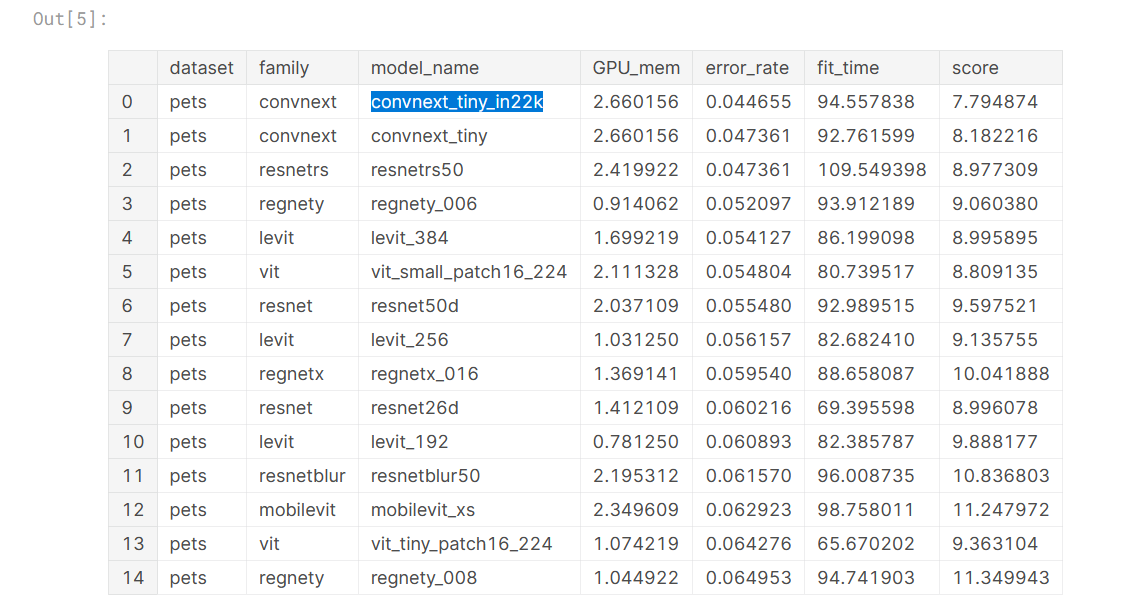

# Submit predictions

In [ ]:
sample_test_files = get_image_files(TEST_DIR)

In [ ]:
[x.stem for x in sorted(sample_test_files)]

In [ ]:
test_dls = dls.test_dl(sorted(sample_test_files))

In [ ]:
test_dls.show_batch()

In [ ]:
sub= pd.read_csv('../input/tpu-getting-started/sample_submission.csv')

In [ ]:
sub.head()

In [ ]:
preds, targs = learn.get_preds(dl=test_dls)
preds_series = pd.Series(preds.argmax(1))

In [ ]:
sub_id_series = pd.Series([x.stem for x in sorted(sample_test_files)])

In [ ]:
preds_series.head(10)

In [ ]:
sub_id_series.head(10)

In [ ]:
sub["id"] = sub_id_series
sub["label"] = preds_series
sub.to_csv("submission.csv", index=False)

In [ ]:
! head submission.csv

In [ ]:
# n = sub.shape[0]
# test_folder = TEST_DIR  

In [ ]:
img = plt.imread(TEST_DIR+'416e24d42.jpeg')
print(learn.predict(img)[0])

In [ ]:
labels = learn.dls.vocab
labels

In [ ]:
mapping = {k: v for k, v in enumerate(labels)}
mapping

In [ ]:
# test_dl = dls.test_dl([TEST_DIR/Path(x) for x in test_images_array])

In [ ]:
# for i in range(n):
#   idc = sub.iloc[i][0]
#   k = TEST_DIR + idc + '.jpeg'
#   k = plt.imread(k)
#   ans = learn.predict(k)[0]
#   for x, y in mapping.items():
#     if y == str(ans):
#       sub.loc[[i],1:] = x

# print("Done Prediction saved ---> ")

In [ ]:
# sub.to_csv('submission.csv', index=False)
# sub.head()

# Ending note <a id="6"></a>

<font size=4 color="red">This concludes my fastai2 kernel. Please upvote this kernel if you like it. It took me more than 30+ hours to write this kernel to get familarised with fastai library.</font>